<a href="https://colab.research.google.com/github/Dharvi-k/Pytorch_Workflow/blob/main/Multi_class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MULTI-CLASS CLASSIFICATION

 **binary classification** problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a **multi-class classification** problem deals with classifying something from a list of more than two options (e.g. classifying a photo as a cat a dog or a chicken).

**Creating multi-class classification data**

---



Specifically, let's do the following:

1. Create some multi-class data with make_blobs().

2. Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).

3. Split the data into training and test sets using train_test_split().

4. Visualize the data.

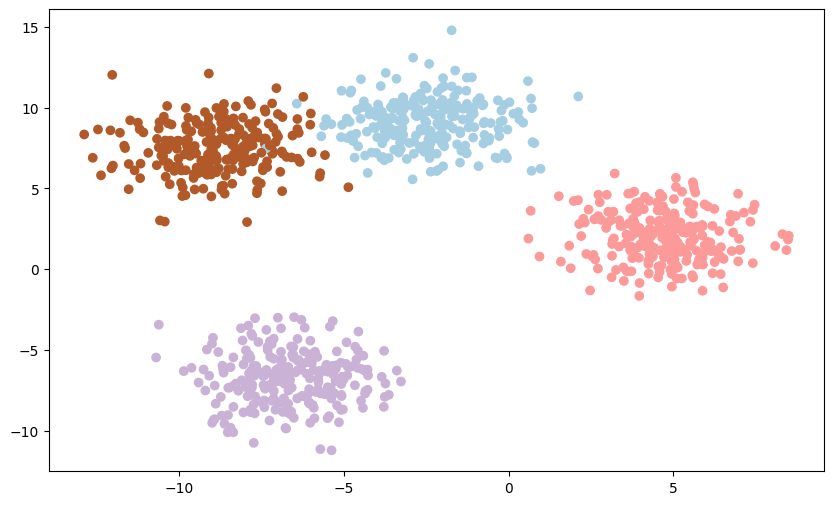

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

# 1. Create multi-class data
x_blob,y_blob=make_blobs(n_samples=1000,          # We want to make 1000 data points in total.
                         n_features=NUM_FEATURES, # X features
                         centers=NUM_CLASSES,     # y labels
                         cluster_std=1.5,         # This controls how spread out each cluster is
                         random_state=RANDOM_SEED)

# 2. Turn data into tensors(Because Scikit-learn (make_blobs) gives us NumPy arrays, but PyTorch needs Tensors.)
x_blob=torch.from_numpy(x_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.float)

# 3. Split into train and test sets
x_blob_train,x_blob_test,y_blob_train,y_blob_test=train_test_split(x_blob,
                                                                   y_blob,
                                                                   random_state=RANDOM_SEED)
# 4. Visualize the data
plt.figure(figsize=(10,6))
plt.scatter(x=x_blob[:,0],
            y=x_blob[:,1],
            c=y_blob,
            cmap=plt.cm.Paired)



we can separate this data without introducing non-linearity in our model as
You could draw two straight lines:


One vertical to split left vs. right


One horizontal to split top vs. bottom


That forms a "plus" shape, dividing the 2D space into 4 clear parts.

so we can separate the classes using linear decision boundaries — no need for complex curved shapes.

Building a multi-class classification model.

In [2]:
# Create a device agnostic code
device='cuda' if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
from torch import nn
# Build model
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4=BlobModel(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

 **Creating a loss function and optimizer for a multi-class PyTorch model**

Since we're working on a multi-class classification problem, we'll use the nn.CrossEntropyLoss() method as our loss function.


And we'll stick with using SGD with a learning rate of 0.1 for optimizing our model_4 parameters.

In [6]:
# create loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_4.parameters(),
                          lr=0.1)

 **Getting prediction probabilities for a multi-class PyTorch model**

Alright, we've got a loss function and optimizer ready, and we're ready to train our model but before we do let's do a single forward pass with our model to see if it works.

In [7]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(x_blob_train.to(device))

tensor([[ 2.4131,  0.6188, -1.0471, -0.5559],
        [ 2.2463,  0.5528, -0.9789, -0.5178],
        [-1.2206,  1.0000, -0.5795, -0.2081],
        ...,
        [ 2.6053,  0.2999, -0.9049, -0.4950],
        [-1.2808,  0.6219, -0.3571, -0.1004],
        [ 1.4835,  1.2248, -1.2115, -0.6018]], grad_fn=<AddmmBackward0>)

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

That's where the softmax activation function comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

In [8]:
# Make prediction logits with model
y_logits=model_4(x_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_prob=torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_prob[:5])


tensor([[ 1.2541, -0.7542, -0.0630, -0.0484],
        [ 2.0258,  1.1334, -1.2620, -0.6446],
        [-1.4675,  0.5264, -0.2687, -0.0520],
        [ 0.4918, -0.6927,  0.0453,  0.0294],
        [ 2.6684,  0.0786, -0.7931, -0.4441]], grad_fn=<SliceBackward0>)
tensor([[0.5974, 0.0802, 0.1600, 0.1624],
        [0.6595, 0.2702, 0.0246, 0.0457],
        [0.0634, 0.4654, 0.2102, 0.2610],
        [0.3883, 0.1188, 0.2484, 0.2445],
        [0.8689, 0.0652, 0.0273, 0.0387]], grad_fn=<SliceBackward0>)


It may still look like the outputs of the softmax function are jumbled numbers (and they are, since our model hasn't been trained and is predicting using random patterns)

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

In [9]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_prob[0])

tensor(1.0000, grad_fn=<SumBackward0>)


These prediction probabilities are essentially saying how much the model thinks the target X sample (the input) maps to each class.


Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using torch.argmax().

In [13]:
# Which class does the model think is *most* likely at the index 0 sample
print(y_pred_prob[0])
print(torch.argmax(y_pred_prob[0]))

tensor([0.5412, 0.4095, 0.0155, 0.0338], grad_fn=<SelectBackward0>)
tensor(0)


**creating a accuracy function**

In [21]:
# let's create a accuracy function
def accuracy_fn(y_true,y_pred):
  correct=(y_true==y_pred).sum().item()
  total=len(y_true)   # total number of samples
  acc=(correct/total)*100  # convert to percentage
  return acc

Of course, right now this is just random guessing. But we can improve those chances by training the model.

**Creating a training and testing loop for a multi-class PyTorch model**

Let's train the model for epochs=100 and evaluate it every 10 epochs.

In [22]:
# fit the model
torch.manual_seed(42)

# set the number of epochs
epochs=100

# put the data on the target device
x_blob_train,x_blob_test=x_blob_train.float().to(device),x_blob_test.float().to(device)
y_blob_train,y_blob_test=y_blob_train.long().to(device),y_blob_test.long().to(device)

for epoch in range(epochs):
  ### Training
  model_4.train()

  # 1. forward pass
  y_logits=model_4(x_blob_train)  # model outputs raw logits
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)   # this picks the index of the highest value in each row.

  # 2. Calculate the loss
  loss=loss_fn(y_logits,y_blob_train)
  acc=accuracy_fn(y_true=y_blob_train,
                  y_pred=y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backward
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits=model_4(x_blob_test)
    test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)
    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

 # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.81963, Acc: 24.80% | Test Loss: 1.00602, Test Acc: 51.20%
Epoch: 10 | Loss: 0.38362, Acc: 97.07% | Test Loss: 0.32719, Test Acc: 99.60%
Epoch: 20 | Loss: 0.14380, Acc: 99.20% | Test Loss: 0.12786, Test Acc: 99.60%
Epoch: 30 | Loss: 0.08762, Acc: 99.33% | Test Loss: 0.07675, Test Acc: 99.20%
Epoch: 40 | Loss: 0.06540, Acc: 99.47% | Test Loss: 0.05570, Test Acc: 99.60%
Epoch: 50 | Loss: 0.05389, Acc: 99.47% | Test Loss: 0.04462, Test Acc: 99.60%
Epoch: 60 | Loss: 0.04698, Acc: 99.47% | Test Loss: 0.03788, Test Acc: 99.60%
Epoch: 70 | Loss: 0.04243, Acc: 99.47% | Test Loss: 0.03339, Test Acc: 99.60%
Epoch: 80 | Loss: 0.03923, Acc: 99.47% | Test Loss: 0.03020, Test Acc: 99.60%
Epoch: 90 | Loss: 0.03688, Acc: 99.47% | Test Loss: 0.02781, Test Acc: 99.60%


**Making and evaluating predictions with a PyTorch multi-class model**

It looks like our trained model is performing pretty well.


But to make sure of this, let's make some predictions and visualize them.

In [27]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits=model_4(x_blob_test)
  y_pred_prob=torch.softmax(y_logits,dim=1).argmax(dim=1)
print(y_pred_prob[:5])  # printing first five predictions

tensor([1, 3, 2, 1, 0])


**Importing helper functions**


In [30]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download


**let's plot the data**


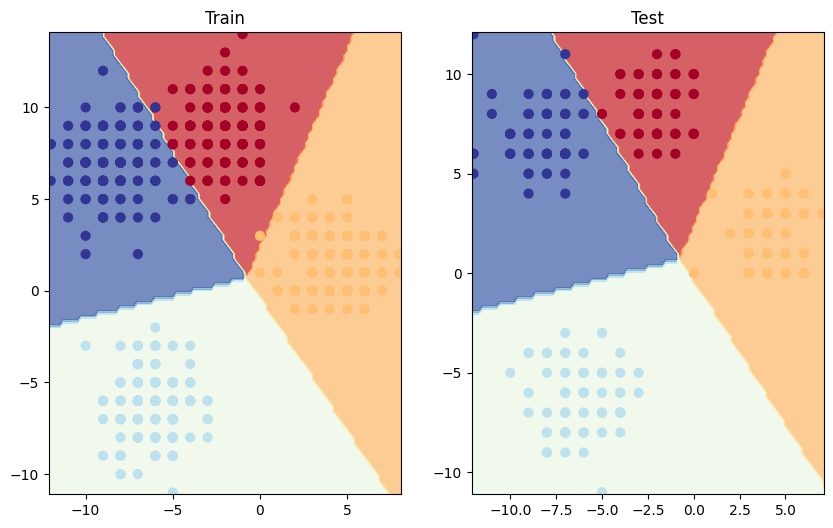

In [32]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, x_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, x_blob_test, y_blob_test)